Copyright 2021 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This solution, including any related sample code or data, is made available 
on an “as is,” “as available,” and “with all faults” basis, solely for 
illustrative purposes, and without warranty or representation of any kind. 
This solution is experimental, unsupported and provided solely for your 
convenience. Your use of it is subject to your agreements with Google, as 
applicable, and may constitute a beta feature as defined under those 
agreements.  To the extent that you make any data available to Google in 
connection with your use of the solution, you represent and warrant that you 
have all necessary and appropriate rights, consents and permissions to permit 
Google to use and process that data.  By using any portion of this solution, 
you acknowledge, assume and accept all risks, known and unknown, associated 
with its usage, including with respect to your deployment of any portion of 
this solution in your systems, or usage in connection with your business, 
if at all.


# Setup

### Load modules

In [5]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

!pip install relativeImp
from relativeImp import relativeImp

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Running on PyMC3 v3.11.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Define Parameters

In [6]:
#@title Parameters

INPUT_SHEET_NAME = 'model input data 9.20.21' #@param {type:"string"}

### Load model input data

In [7]:
google_sheets_name = INPUT_SHEET_NAME #@param

In [8]:
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

In [9]:
'''
%%bigquery df
SELECT *
FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`
WHERE Division IS NOT NULL;
'''

'\n%%bigquery df\nSELECT *\nFROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`\nWHERE Division IS NOT NULL;\n'

In [10]:
df = df[['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Brand_x_Core_x_NC_clicks             607 non-null    float64
 1   The_Trade_Desk_x_Audio_x_AWA_imps    607 non-null    float64
 2   DBM_x_Display_x_RTG_imps             607 non-null    float64
 3   Amazon_x_Display_x_AWA_imps          607 non-null    float64
 4   DBM_x_Video_x_AWA_imps               607 non-null    float64
 5   The_Trade_Desk_x_Display_x_AWA_imps  607 non-null    float64
 6   Brand_x_RMKT_x_EC_clicks             607 non-null    float64
 7   OTHER_x_Display_x_AWA_imps           607 non-null    float64
 8   Amazon_x_Display_x_RTG_imps          607 non-null    float64
 9   DBM_x_Display_x_ACQ_imps             607 non-null    float64
 10  Oath_x_Display_x_AWA_imps            607 non-null    float64
 11  DBM_x_Display_x_AWA_imps        

In [12]:
df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
0,0.67162,0.26662,0.69634,0.11681,0.63202,0.00000,0.23069,0.25650,0.79894,0.89166,0.00000,0.95458,1653
1,0.40299,0.20180,0.49411,0.28042,0.09443,0.00000,0.10479,0.69262,0.53563,0.19709,0.00000,0.28003,1466
2,0.08896,0.13215,0.53878,0.22092,0.04362,0.00000,0.02953,0.64816,0.58880,0.21123,0.00000,0.14691,604
3,0.21182,0.21214,0.65453,0.53228,0.09934,0.00000,0.05551,0.88852,0.69746,0.19238,0.00000,0.30710,891
4,0.35781,0.25082,0.53687,0.11934,0.53733,0.00000,0.13340,0.04615,0.16582,0.67209,0.00000,0.64651,1023


In [13]:
df.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,0.47118,0.11441,0.57972,0.14667,0.12983,0.07023,0.28329,0.28399,0.21308,0.18824,0.16550,0.22028,1500.76277
std,0.16844,0.15197,0.20971,0.22154,0.15098,0.17215,0.20413,0.27005,0.25665,0.18653,0.22315,0.24301,459.59147
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,365.00000
25%,0.35525,0.00000,0.51710,0.00000,0.00000,0.00000,0.12363,0.06260,0.00000,0.09887,0.00000,0.03567,1174.00000
50%,0.46720,0.05341,0.61904,0.03434,0.08333,0.00000,0.21037,0.15580,0.00000,0.13576,0.00000,0.13662,1478.00000
75%,0.58713,0.19618,0.70289,0.23873,0.22359,0.00000,0.41195,0.49225,0.41618,0.21503,0.29745,0.28018,1697.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3011.00000


In [14]:
#df.fillna(0, inplace = True)

In [15]:
KPI_COL = "new_accounts" #@param {type: "string"}

In [16]:
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

In [17]:
df[df.columns[df.columns != KPI_COL]]

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps
0,0.67162,0.26662,0.69634,0.11681,0.63202,0.00000,0.23069,0.25650,0.79894,0.89166,0.00000,0.95458
1,0.40299,0.20180,0.49411,0.28042,0.09443,0.00000,0.10479,0.69262,0.53563,0.19709,0.00000,0.28003
2,0.08896,0.13215,0.53878,0.22092,0.04362,0.00000,0.02953,0.64816,0.58880,0.21123,0.00000,0.14691
3,0.21182,0.21214,0.65453,0.53228,0.09934,0.00000,0.05551,0.88852,0.69746,0.19238,0.00000,0.30710
4,0.35781,0.25082,0.53687,0.11934,0.53733,0.00000,0.13340,0.04615,0.16582,0.67209,0.00000,0.64651
5,0.22983,0.19187,0.61374,0.01233,0.02539,0.00000,0.06564,0.62969,0.70969,0.15151,0.00000,0.08991
6,0.53126,0.32468,0.80804,0.11255,0.62237,0.00000,0.18289,0.86159,0.92159,0.76005,0.00000,1.00000
7,0.28167,0.18766,0.62208,0.06647,0.02581,0.00000,0.09934,0.63782,0.50682,0.12999,0.00000,0.09445
8,0.48074,0.13538,0.64457,0.26061,0.04578,0.00000,0.14034,0.64996,0.67043,0.21654,0.00000,0.16641
9,0.31000,0.20233,0.65056,0.00846,0.02785,0.00000,0.10019,0.69520,0.39629,0.18044,0.00000,0.08722


## OLS Model with Sklearn

In [18]:
reg = LinearRegression().fit(X,y)

In [19]:
df.columns.to_list()

['Brand_x_Core_x_NC_clicks',
 'The_Trade_Desk_x_Audio_x_AWA_imps',
 'DBM_x_Display_x_RTG_imps',
 'Amazon_x_Display_x_AWA_imps',
 'DBM_x_Video_x_AWA_imps',
 'The_Trade_Desk_x_Display_x_AWA_imps',
 'Brand_x_RMKT_x_EC_clicks',
 'OTHER_x_Display_x_AWA_imps',
 'Amazon_x_Display_x_RTG_imps',
 'DBM_x_Display_x_ACQ_imps',
 'Oath_x_Display_x_AWA_imps',
 'DBM_x_Display_x_AWA_imps',
 'new_accounts']

In [20]:
reg.score(X,y)

0.761768653992274

In [21]:
reg.intercept_

611.8055953514976

In [22]:
coefficients = reg.coef_.tolist()

In [23]:
coefficients

[2242.3324273669105,
 30.86763340137918,
 215.93171283528923,
 340.3547502673182,
 614.2961219867805,
 434.47845563935533,
 -1023.914352765046,
 -177.12248512266552,
 -132.57519477215888,
 644.9300658535224,
 163.91957788172297,
 -1073.2664182293524]

In [24]:
len(df.columns[df.columns != KPI_COL])

12

In [25]:
coef_df = pd.DataFrame({'feature': df.columns[df.columns != KPI_COL],'coef': coefficients})

In [26]:
coef_df

,feature,coef
0,Brand_x_Core_x_NC_clicks,2242.33243
1,The_Trade_Desk_x_Audio_x_AWA_imps,30.86763
2,DBM_x_Display_x_RTG_imps,215.93171
3,Amazon_x_Display_x_AWA_imps,340.35475
4,DBM_x_Video_x_AWA_imps,614.29612
5,The_Trade_Desk_x_Display_x_AWA_imps,434.47846
6,Brand_x_RMKT_x_EC_clicks,-1023.91435
7,OTHER_x_Display_x_AWA_imps,-177.12249
8,Amazon_x_Display_x_RTG_imps,-132.57519
9,DBM_x_Display_x_ACQ_imps,644.93007


In [27]:
Y_prediction = reg.predict(X) # predicted values to be used for residual calculations

In [28]:
mean_absolute_error(y,Y_prediction)

175.1297644594688

In [29]:
mean_squared_error(y,Y_prediction)

50237.353321931485

In [30]:
rmse = np.sqrt(mean_squared_error(y,Y_prediction))
rmse

224.1369075407517

In [31]:
residuals = Y_prediction - y

#### Calculate relative importance of each tactic

In [32]:
yName = 'new_accounts'
xNames = ['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps']
df_results = relativeImp(df, outcomeName = yName, driverNames = xNames)

In [33]:
df_results

,driver,rawRelaImpt,normRelaImpt
0,Brand_x_Core_x_NC_clicks,0.43880,57.60272
1,The_Trade_Desk_x_Audio_x_AWA_imps,0.01257,1.64967
2,DBM_x_Display_x_RTG_imps,0.03929,5.15810
3,Amazon_x_Display_x_AWA_imps,0.04937,6.48138
4,DBM_x_Video_x_AWA_imps,0.04345,5.70385
5,The_Trade_Desk_x_Display_x_AWA_imps,0.06228,8.17543
6,Brand_x_RMKT_x_EC_clicks,0.04092,5.37235
7,OTHER_x_Display_x_AWA_imps,0.01419,1.86288
8,Amazon_x_Display_x_RTG_imps,0.01035,1.35834
9,DBM_x_Display_x_ACQ_imps,0.01053,1.38265


### Cross-Validation

#### Leave One Out

In [34]:
loo = LeaveOneOut()
scores_mse_loo = cross_val_score(reg, X, y, scoring="neg_mean_squared_error", cv=loo)
mse_loo = np.mean(np.abs(scores_mse_loo))
rmse_loo = np.sqrt(mse_loo)

In [35]:
# initiate list for loop to aggregate metric results

X_array = np.array(X) 
Y_array = np.array(y)

Y_true = []
Y_hat = []
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    Y_train, Y_test = Y_array[train_idx], Y_array[test_idx]
    
   
    reg.fit(X = X_train, y = Y_train) 
    Y_pred = reg.predict(X_test)
        
    Y_true += list(Y_test)
    Y_hat += list(Y_pred)
       
r2_loo = r2_score(np.array(Y_true), np.array(Y_hat))
mae_loo = mean_absolute_error(np.array(Y_true), np.array(Y_hat))

#### Leave P Out

In [36]:
#@title Input P for hold-out size (for model cross validation using leave-P-out)
P_HOLD_OUT = 2 #@param {type: "integer"}

In [37]:
# model cross validation using leave-P-out (specify P as hold-out size)
lpo = LeavePOut(p=P_HOLD_OUT)
scores_mse_lpo = cross_val_score(reg, X, y, scoring="neg_mean_squared_error", cv=lpo) 
mse_lpo = np.mean(np.abs(scores_mse_lpo))
rmse_lpo = np.sqrt(mse_lpo)

# initiate list for loop to aggregate metric results (overrides arrays created above)
Y_true = []
Y_hat = []
for train_idx, test_idx in lpo.split(X):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    Y_train, Y_test = Y_array[train_idx], Y_array[test_idx]
    
    reg.fit(X = X_train, y = Y_train) 
    Y_pred = reg.predict(X_test)
        
    Y_true += list(Y_test)
    Y_hat += list(Y_pred)
        
r2_lpo = r2_score(np.array(Y_true), np.array(Y_hat))
mae_lpo = mean_absolute_error(np.array(Y_true), np.array(Y_hat))

#### Evaluation

Compare scoring

In [38]:
cv_df = pd.DataFrame(columns=('CV Method','MAE','R2', 'MSE', 'RMSE')) 
cv_df.loc[len(cv_df)] = ['LOO',mae_loo, r2_loo[0], mse_loo, rmse_loo]
cv_df.loc[len(cv_df)] = ['LPO',mae_lpo, r2_lpo[0], mse_lpo, rmse_lpo]
cv_df

,CV Method,MAE,R2,MSE,RMSE
0,LOO,178.99887,0.75361,52643.20965,229.44108
1,LPO,179.00165,0.75360,52645.29988,229.44564


# Validate Linear Regression Model Assumptions

####1. Linearity

Visually inspect linearity between target variable and predictions

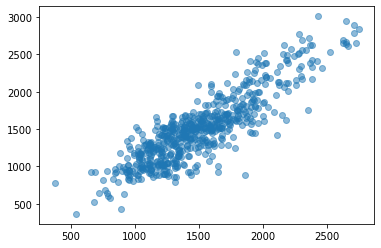

In [39]:
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

#### 2. Normality of Errors

Visually inspect the residuals to confirm normality

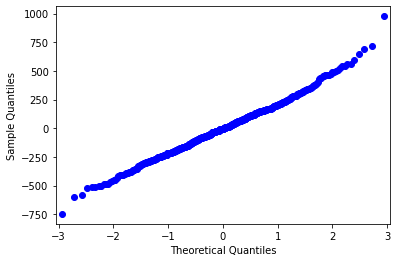

In [40]:
fig = sm.qqplot(residuals)

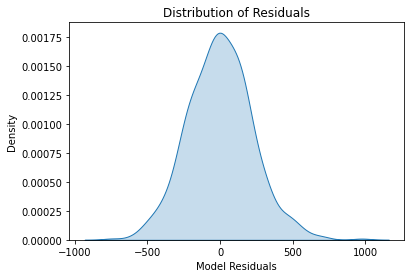

In [41]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

####3. Absence of Multicollinearity

Tested and checked during data processing stage

####4. Homoscedasticity


Visually inspect residuals to confirm constant variance

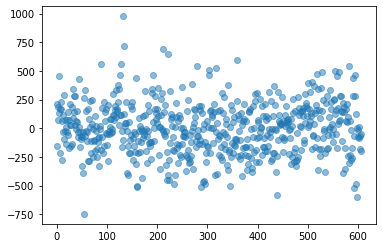

In [42]:
plt.plot(residuals,'o',alpha=0.5)
plt.show()